In [62]:
import pandas as pd
import yaml
import ast
import numpy as np
root_path = '/local/work/merengelke/aipal/'
config = yaml.load(open('cfg.yaml', 'r'), Loader=yaml.FullLoader)

cities_countries = config['cities_countries']
paths = [f"{root_path}{city_country}/aipal/results.csv" for city_country in cities_countries]
results_paths = [f"{root_path}{city_country}/aipal/predict.csv" for city_country in cities_countries]

df = pd.DataFrame()
for path in paths:
    df_small = pd.read_csv(path)
    df_small['city_country'] = path.split('/')[-3]
    df = pd.concat([df, df_small])

df_results = pd.DataFrame()
for path in results_paths:
    df_small = pd.read_csv(path)

    df_small['city_country'] = path.split('/')[-3]

    df_results = pd.concat([df_results, df_small])

# age over 18
if config['is_adult']:
    # drop all columns with name kids in it
    df = df.loc[:, ~df.columns.str.contains('kids')]
else:
    df = df.loc[:, ~df.columns.str.contains('adults')]
    
df.rename(columns={'Unnamed: 0': 'class'}, inplace=True)

if config['is_adult']:
    df = df[df['city_country'] != 'Vessen']

In [57]:
df.columns

Index(['class', 'no cutoff - adults', 'overall cutoff - adults',
       'confident cutoff - adults', 'city_country'],
      dtype='object')

In [58]:
# df = df[['no cutoff - adults', 'class','city_country']].dropna()
# no cutoff - adults, overall cutoff - adults, confident cutoff - adults	

In [59]:

# Safely evaluate and extract the F1 Score, handling potential NaN and malformed data
import numpy as np


def safe_eval_f1_score(row):
    try:
        # Convert the string representation of a dictionary into an actual dictionary
        data = ast.literal_eval(row)
        return data['F1 Score'][0]
    except (ValueError, SyntaxError, KeyError, TypeError):
        # Return NaN if eval or accessing the dictionary fails
        return np.nan

# Apply the function to the entire DataFrame
df['F1 Score'] = df['no cutoff - adults'].apply(lambda x: safe_eval_f1_score(x) if pd.notna(x) else np.nan)

df_counts = df_results.groupby(['city_country', 'class']).size().reset_index(name='counts')


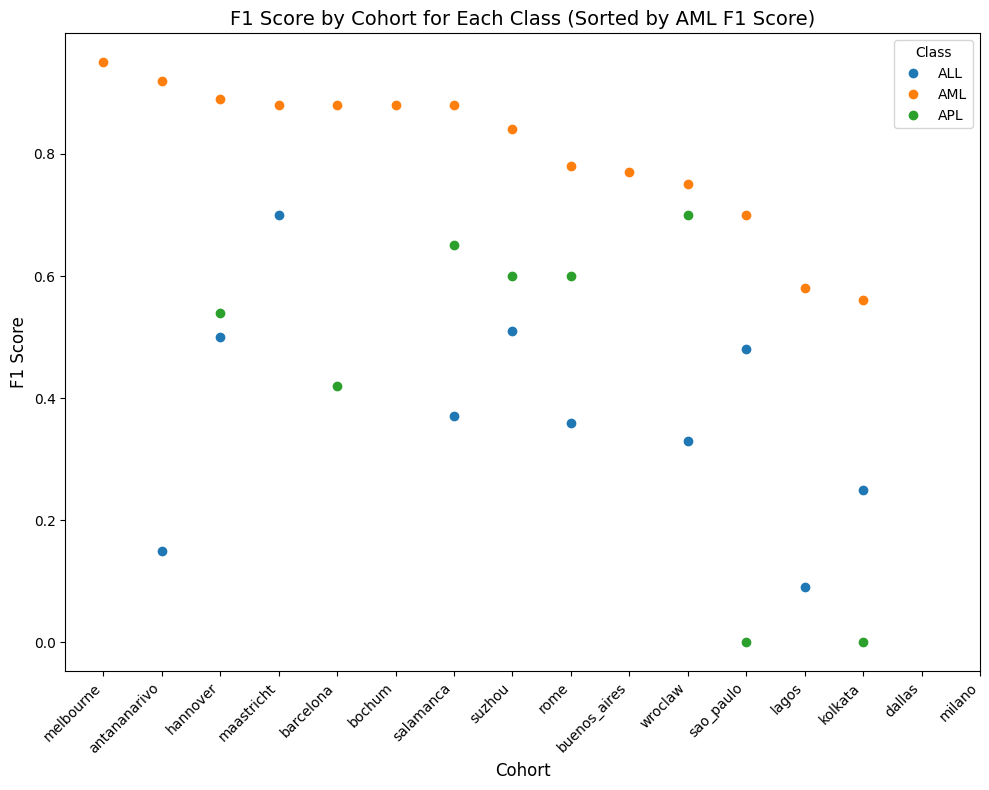

In [60]:
# Get AML F1 scores and sort cohorts by them
from matplotlib import pyplot as plt


aml_scores = df[df['class'] == 'AML'].set_index('city_country')['F1 Score']
sorted_cohorts = aml_scores.sort_values(ascending=False).index

# Group the dataframe by 'class'
grouped = df.groupby('class')

# Create a plot for each class
plt.figure(figsize=(10, 8))

for class_name, group in grouped:
    # Reindex the group data according to the sorted cohorts
    sorted_data = group.set_index('city_country').reindex(sorted_cohorts)
    plt.plot(range(len(sorted_cohorts)), sorted_data['F1 Score'], 
             marker='o', linestyle='None', label=class_name)

# Set x-ticks to the sorted cohort names
plt.xticks(range(len(sorted_cohorts)), sorted_cohorts, rotation=45, ha='right')

# Add title and labels
plt.title('F1 Score by Cohort for Each Class (Sorted by AML F1 Score)', fontsize=14)
plt.xlabel('Cohort', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)

# Show legend
plt.legend(title="Class")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

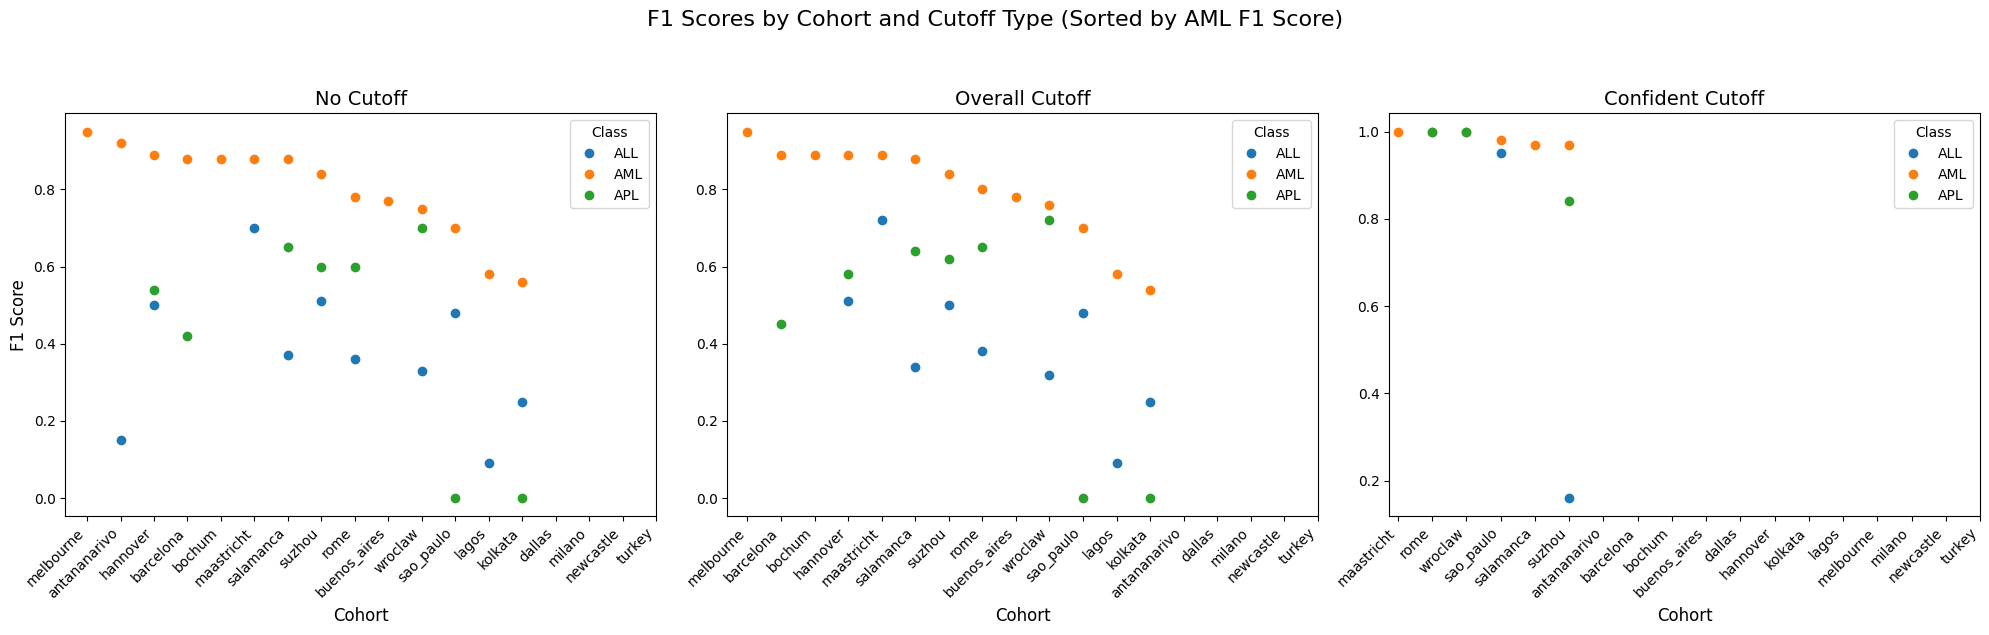

In [64]:
# Create figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

cutoff_types = ['no cutoff - adults', 'overall cutoff - adults', 'confident cutoff - adults']
titles = ['No Cutoff', 'Overall Cutoff', 'Confident Cutoff']

for idx, (cutoff, title) in enumerate(zip(cutoff_types, titles)):
    # Calculate F1 scores for current cutoff
    df[f'F1 Score_{idx}'] = df[cutoff].apply(lambda x: safe_eval_f1_score(x) if pd.notna(x) else np.nan)
    
    # Get AML F1 scores and sort cohorts
    aml_data = df[df['class'] == 'AML'].groupby('city_country')[f'F1 Score_{idx}'].mean()
    sorted_cohorts = aml_data.sort_values(ascending=False).index
    
    # Plot each class
    for class_name, group in df.groupby('class'):
        # Calculate mean F1 scores for each city_country
        mean_scores = group.groupby('city_country')[f'F1 Score_{idx}'].mean()
        # Reorder based on sorted_cohorts
        plot_data = mean_scores.reindex(sorted_cohorts)
        
        axes[idx].plot(range(len(sorted_cohorts)), plot_data.values, 
                      marker='o', linestyle='None', label=class_name)
    
    # Customize subplot
    axes[idx].set_xticks(range(len(sorted_cohorts)))
    axes[idx].set_xticklabels(sorted_cohorts, rotation=45, ha='right')
    axes[idx].set_title(f'{title}', fontsize=14)
    axes[idx].set_xlabel('Cohort', fontsize=12)
    if idx == 0:  # Only add y-label to the first subplot
        axes[idx].set_ylabel('F1 Score', fontsize=12)
    axes[idx].legend(title="Class")

plt.suptitle('F1 Scores by Cohort and Cutoff Type (Sorted by AML F1 Score)', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()